In [22]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"
import warnings
warnings.filterwarnings("ignore")

In [23]:
# --- LIBRARIES ---
import os
import warnings
import contextlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
# --- SETTINGS ---
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['XGBOOST_DISABLE_WARNINGS'] = '1'

In [25]:
# --- LOAD DATA ---
paths = {
    'features': 'binary_items_dataset.xlsx',
    'sociodemo': 'sociodemographic_data.xlsx',
    'risk': 'turnos_completos_unicos_risk.xlsx'
}
features = pd.read_excel(paths['features'])
sociodemo = pd.read_excel(paths['sociodemo'])
risk = pd.read_excel(paths['risk'])

In [26]:
# --- MERGE DATASETS ---
df = features.merge(sociodemo, on='NHC', how='left')
df = df.merge(risk[['Fecha', 'Turno', 'Aggressive', 'Self-Harm', 'Absconding']], on=['Fecha', 'Turno'], how='left')

In [27]:
# --- LABELING ---
def assign_multiclass(row):
    if pd.notna(row['Aggressive']): return 'Aggressive'
    if pd.notna(row['Self-Harm']): return 'Self-Harm'
    if pd.notna(row['Absconding']): return 'Absconding'
    return 'No_risk'

def assign_binary(row):
    if pd.notna(row['Aggressive']) or pd.notna(row['Self-Harm']) or pd.notna(row['Absconding']):
        return 'Risk'
    return 'No_Risk'

df['Risk_Multiclass'] = df.apply(assign_multiclass, axis=1)
df['Risk_Binary'] = df.apply(assign_binary, axis=1)
df = df[df['Risk_Binary'].notna()]

In [28]:
# --- FEATURE PREPROCESSING ---
drop_cols = ['NHC', 'Fecha', 'Turno', 'Aggressive', 'Self-Harm', 'Absconding', 'Risk_Multiclass', 'Risk_Binary']
X = df.drop(columns=drop_cols)
y = df['Risk_Binary'].map({'No_Risk': 0, 'Risk': 1})
groups = df['NHC']

X = pd.get_dummies(X, drop_first=True)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [29]:
# --- DATA OVERVIEW ---
print("Number of samples:", X_scaled.shape[0])
print("Number of variables after dummies:", X_scaled.shape[1])
print("Binary classes (0=No_Risk, 1=Risk):")
print(y.value_counts())

# Sample preview
print("\nSample of labeled data:")
preview = df[['NHC', 'Fecha', 'Turno', 'Risk_Binary']].copy()
display(preview.sample(5, random_state=42))

Number of samples: 637
Number of variables after dummies: 42
Binary classes (0=No_Risk, 1=Risk):
Risk_Binary
0    415
1    222
Name: count, dtype: int64

Sample of labeled data:


,NHC,Fecha,Turno,Risk_Binary
260,14408575,2024-12-02,M,No_Risk
228,307126,2025-01-08,N,No_Risk
31,21360689,2024-03-21,T,Risk
507,356711,2024-03-27,N,No_Risk
503,407748,2024-04-01,T,No_Risk


In [30]:
# --- LOGISTIC REGRESSION (BINARY CLASSIFICATION - LOPOCV) ---
from sklearn.linear_model import LogisticRegression

logo = LeaveOneGroupOut()
model_logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

y_true_logreg, y_pred_logreg = [], []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_logreg.fit(X_train, y_train)
    y_pred = model_logreg.predict(X_test)

    y_true_logreg.extend(y_test)
    y_pred_logreg.extend(y_pred)

print("\n--- LOGISTIC REGRESSION – BINARY CLASSIFICATION (LOPOCV) ---")
print(classification_report(y_true_logreg, y_pred_logreg, target_names=["No_Risk", "Risk"]))


--- LOGISTIC REGRESSION – BINARY CLASSIFICATION (LOPOCV) ---
              precision    recall  f1-score   support

     No_Risk       0.72      0.76      0.74       415
        Risk       0.50      0.46      0.48       222

    accuracy                           0.65       637
   macro avg       0.61      0.61      0.61       637
weighted avg       0.65      0.65      0.65       637



In [31]:
pd.DataFrame({
    'y_true_logreg': y_true_logreg,
    'y_pred_logreg': y_pred_logreg
}).to_csv('logreg_bin_lopocv.csv', index=False)

In [32]:
# --- RANDOM FOREST (BINARY CLASSIFICATION - LOPOCV) ---
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

y_true_rf, y_pred_rf = [], []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)

    y_true_rf.extend(y_test)
    y_pred_rf.extend(y_pred)

print("\n--- RANDOM FOREST – BINARY CLASSIFICATION (LOPOCV) ---")
print(classification_report(y_true_rf, y_pred_rf, target_names=["No_Risk", "Risk"]))


--- RANDOM FOREST – BINARY CLASSIFICATION (LOPOCV) ---
              precision    recall  f1-score   support

     No_Risk       0.72      0.81      0.76       415
        Risk       0.53      0.40      0.45       222

    accuracy                           0.67       637
   macro avg       0.62      0.61      0.61       637
weighted avg       0.65      0.67      0.66       637



In [33]:
pd.DataFrame({
    'y_true_rf': y_true_rf,
    'y_pred_rf': y_pred_rf
}).to_csv('rf_bin_lopocv.csv', index=False)

In [34]:
# --- XGBOOST (BINARY CLASSIFICATION - LOPOCV) ---
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

y_true_xgb, y_pred_xgb = [], []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)

    y_true_xgb.extend(y_test)
    y_pred_xgb.extend(y_pred)

print("\n--- XGBOOST – BINARY CLASSIFICATION (LOPOCV) ---")
print(classification_report(y_true_xgb, y_pred_xgb, target_names=["No_Risk", "Risk"]))


--- XGBOOST – BINARY CLASSIFICATION (LOPOCV) ---
              precision    recall  f1-score   support

     No_Risk       0.73      0.81      0.77       415
        Risk       0.55      0.44      0.49       222

    accuracy                           0.68       637
   macro avg       0.64      0.62      0.63       637
weighted avg       0.67      0.68      0.67       637



In [35]:
pd.DataFrame({
    'y_true_xgb': y_true_xgb,
    'y_pred_xgb': y_pred_xgb
}).to_csv('xg_bin_lopocv.csv', index=False)

In [36]:
# --- MULTICLASS LOGISTIC REGRESSION (LOPOCV) ---
from sklearn.preprocessing import LabelEncoder

# Prepare multiclass dataset
df_mc = df[df['Risk_Multiclass'].notna()].copy()
X_mc = df_mc.drop(columns=drop_cols)
X_mc = pd.get_dummies(X_mc, drop_first=True)
y_mc = LabelEncoder().fit_transform(df_mc['Risk_Multiclass'])
groups_mc = df_mc['NHC']
labels_map = dict(enumerate(LabelEncoder().fit(df_mc['Risk_Multiclass']).classes_))

# Impute and scale
X_mc_imputed = imputer.fit_transform(X_mc)
X_mc_scaled = scaler.fit_transform(X_mc_imputed)

# Logistic Regression
model_log_mc = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    penalty='l2',
    multi_class='multinomial'
)

y_true_mc_log, y_pred_mc_log = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]

    model_log_mc.fit(X_train, y_train)
    y_pred = model_log_mc.predict(X_test)

    y_true_mc_log.extend(y_test)
    y_pred_mc_log.extend(y_pred)

# Report
y_true_named = pd.Series(y_true_mc_log).map(labels_map)
y_pred_named = pd.Series(y_pred_mc_log).map(labels_map)

print("\n--- LOGISTIC REGRESSION – MULTICLASS CLASSIFICATION (LOPOCV) ---")
print(classification_report(y_true_named, y_pred_named))


--- LOGISTIC REGRESSION – MULTICLASS CLASSIFICATION (LOPOCV) ---
              precision    recall  f1-score   support

  Absconding       0.08      0.62      0.15        29
  Aggressive       0.34      0.28      0.31       162
     No_risk       0.76      0.42      0.54       415
   Self-Harm       0.14      0.23      0.17        31

    accuracy                           0.39       637
   macro avg       0.33      0.39      0.29       637
weighted avg       0.59      0.39      0.45       637



In [37]:
pd.DataFrame({
    'y_true_named': y_true_named,
    'y_pred_named': y_pred_named
}).to_csv('lg_mc_lopocv.csv', index=False)

In [38]:
# --- MULTICLASS RANDOM FOREST (LOPOCV) ---
model_rf_mc = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

y_true_mc_rf, y_pred_mc_rf = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]

    model_rf_mc.fit(X_train, y_train)
    y_pred = model_rf_mc.predict(X_test)

    y_true_mc_rf.extend(y_test)
    y_pred_mc_rf.extend(y_pred)

y_true_named_rf = pd.Series(y_true_mc_rf).map(labels_map)
y_pred_named_rf = pd.Series(y_pred_mc_rf).map(labels_map)

print("\n--- RANDOM FOREST – MULTICLASS CLASSIFICATION (LOPOCV) ---")
print(classification_report(y_true_named_rf, y_pred_named_rf))


--- RANDOM FOREST – MULTICLASS CLASSIFICATION (LOPOCV) ---
              precision    recall  f1-score   support

  Absconding       0.09      0.62      0.16        29
  Aggressive       0.48      0.36      0.41       162
     No_risk       0.85      0.53      0.65       415
   Self-Harm       0.43      0.74      0.54        31

    accuracy                           0.50       637
   macro avg       0.46      0.56      0.44       637
weighted avg       0.70      0.50      0.56       637



In [39]:
pd.DataFrame({
    'y_true_named_rf': y_true_named_rf,
    'y_pred_named_rf': y_pred_named_rf
}).to_csv('rf_mc_lopocv.csv', index=False)

In [40]:
# --- MULTICLASS XGBOOST (LOPOCV) ---
model_xgb_mc = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

y_true_mc_xgb, y_pred_mc_xgb = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]

    model_xgb_mc.fit(X_train, y_train)
    y_pred = model_xgb_mc.predict(X_test)

    y_true_mc_xgb.extend(y_test)
    y_pred_mc_xgb.extend(y_pred)

y_true_named_xgb = pd.Series(y_true_mc_xgb).map(labels_map)
y_pred_named_xgb = pd.Series(y_pred_mc_xgb).map(labels_map)

print("\n--- XGBOOST – MULTICLASS CLASSIFICATION (LOPOCV) ---")
print(classification_report(y_true_named_xgb, y_pred_named_xgb))


--- XGBOOST – MULTICLASS CLASSIFICATION (LOPOCV) ---
              precision    recall  f1-score   support

  Absconding       0.00      0.00      0.00        29
  Aggressive       0.45      0.25      0.32       162
     No_risk       0.68      0.86      0.76       415
   Self-Harm       0.06      0.03      0.04        31

    accuracy                           0.63       637
   macro avg       0.30      0.29      0.28       637
weighted avg       0.56      0.63      0.58       637



In [41]:
pd.DataFrame({
    'y_true_named_xgb': y_true_named_xgb,
    'y_pred_named_xgb': y_pred_named_xgb
}).to_csv('xg_mc_lopocv.csv', index=False)

In [42]:
# --- BINARY CLASSIFICATION (GROUPED BY DAY using Leave-One-Day-Out) ---
y_true_day_dict = {}
y_pred_day_dict = {}

groups_by_day = df['Fecha']  # Group by date of observation

models_bin = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=y.value_counts()[0] / y.value_counts()[1], random_state=42)
}

for name, model in models_bin.items():
    y_true_day, y_pred_day = [], []
    logo = LeaveOneGroupOut()
    
    for train_idx, test_idx in logo.split(X_scaled, y, groups_by_day):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        y_true_day.extend(y_test)
        y_pred_day.extend(preds)

    print(f"\n--- {name} – BINARY CLASSIFICATION (GROUPED BY DAY) ---")
    print(classification_report(y_true_day, y_pred_day, target_names=["No_Risk", "Risk"]))


--- Logistic Regression – BINARY CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

     No_Risk       0.78      0.77      0.77       415
        Risk       0.58      0.59      0.58       222

    accuracy                           0.71       637
   macro avg       0.68      0.68      0.68       637
weighted avg       0.71      0.71      0.71       637


--- Random Forest – BINARY CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

     No_Risk       0.79      0.85      0.82       415
        Risk       0.67      0.59      0.63       222

    accuracy                           0.76       637
   macro avg       0.73      0.72      0.72       637
weighted avg       0.75      0.76      0.75       637


--- XGBoost – BINARY CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

     No_Risk       0.80      0.83      0.81       415
        Risk       0.66      0.62      0.64  

In [43]:
results_by_day = {}

for name, model in models_bin.items():
    y_true_day, y_pred_day = [], []
    logo = LeaveOneGroupOut()
    
    for train_idx, test_idx in logo.split(X_scaled, y, groups_by_day):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        y_true_day.extend(y_test)
        y_pred_day.extend(preds)

    print(f"\n--- {name} – BINARY CLASSIFICATION (GROUPED BY DAY) ---")
    print(classification_report(y_true_day, y_pred_day, target_names=["No_Risk", "Risk"]))

    df_preds = pd.DataFrame({'y_true': y_true_day, 'y_pred': y_pred_day})
    df_preds.to_csv(f'preds_by_day_{name.replace(" ", "_").lower()}.csv', index=False)

    results_by_day[name] = df_preds


--- Logistic Regression – BINARY CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

     No_Risk       0.78      0.77      0.77       415
        Risk       0.58      0.59      0.58       222

    accuracy                           0.71       637
   macro avg       0.68      0.68      0.68       637
weighted avg       0.71      0.71      0.71       637


--- Random Forest – BINARY CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

     No_Risk       0.79      0.85      0.82       415
        Risk       0.67      0.59      0.63       222

    accuracy                           0.76       637
   macro avg       0.73      0.72      0.72       637
weighted avg       0.75      0.76      0.75       637


--- XGBoost – BINARY CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

     No_Risk       0.80      0.83      0.81       415
        Risk       0.66      0.62      0.64  

In [44]:
# --- MULTICLASS CLASSIFICATION (GROUPED BY DAY using Leave-One-Day-Out) ---

groups_by_day_mc = df_mc['Fecha']  # Use same filtered multiclass df

models_mc = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(num_class=4, eval_metric='mlogloss', random_state=42)
}

results_mc_by_day = {} 

for name, model in models_mc.items():
    y_true_day_mc, y_pred_day_mc = [], []
    logo = LeaveOneGroupOut()

    for train_idx, test_idx in logo.split(X_mc_scaled, y_mc, groups_by_day_mc):
        X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
        y_train, y_test = y_mc[train_idx], y_mc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        y_true_day_mc.extend(y_test)
        y_pred_day_mc.extend(preds)

    y_true_named = pd.Series(y_true_day_mc).map(labels_map)
    y_pred_named = pd.Series(y_pred_day_mc).map(labels_map)

    print(f"\n--- {name} – MULTICLASS CLASSIFICATION (GROUPED BY DAY) ---")
    print(classification_report(y_true_named, y_pred_named))
    
    # <--- GUARDA EN EL DICCIONARIO
    results_mc_by_day[name] = {
        'y_true': y_true_named,
        'y_pred': y_pred_named
    }


--- Logistic Regression – MULTICLASS CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

  Absconding       0.09      0.59      0.16        29
  Aggressive       0.54      0.56      0.55       162
     No_risk       0.87      0.43      0.58       415
   Self-Harm       0.32      0.77      0.46        31

    accuracy                           0.49       637
   macro avg       0.46      0.59      0.43       637
weighted avg       0.72      0.49      0.55       637


--- Random Forest – MULTICLASS CLASSIFICATION (GROUPED BY DAY) ---
              precision    recall  f1-score   support

  Absconding       0.10      0.59      0.17        29
  Aggressive       0.60      0.54      0.57       162
     No_risk       0.87      0.56      0.68       415
   Self-Harm       0.45      0.74      0.56        31

    accuracy                           0.56       637
   macro avg       0.50      0.61      0.49       637
weighted avg       0.75      0.56      0.62

In [45]:
for name, result in results_mc_by_day.items():
    df_preds_mc = pd.DataFrame({
        'y_true': result['y_true'],
        'y_pred': result['y_pred']
    })
    df_preds_mc.to_csv(f'preds_multiclass_by_day_{name.replace(" ", "_").lower()}.csv', index=False)

In [46]:
# --- DEEP LEARNING – BINARY CLASSIFICATION (GROUPED BY TURN) ---

# Ensure float32 type for TensorFlow
X_dl = X_scaled.astype(np.float32)
y_dl = y.astype(np.float32)
groups_turno = df['NHC']

def create_binary_nn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# LOPOCV by patient
y_true_nn, y_pred_nn = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_dl, y_dl, groups_turno):
    X_train, X_test = X_dl[train_idx], X_dl[test_idx]
    y_train, y_test = y_dl[train_idx], y_dl[test_idx]

    model = create_binary_nn(X_train.shape[1])
    early_stop = EarlyStopping(patience=2, restore_best_weights=True, verbose=0)

    model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1,
              callbacks=[early_stop], verbose=0)

    preds = model.predict(X_test).flatten()
    y_pred_nn.extend((preds >= 0.5).astype(int))
    y_true_nn.extend(y_test)

print("\n--- DEEP LEARNING – BINARY CLASSIFICATION (GROUPED BY TURN) ---")
print(classification_report(y_true_nn, y_pred_nn, target_names=["No_Risk", "Risk"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [47]:
df_nn_preds = pd.DataFrame({
    'y_true': y_true_nn,
    'y_pred': y_pred_nn
})
df_nn_preds.to_csv('deep_binary_by_turn.csv', index=False)

In [48]:
# --- DEEP LEARNING – BINARY CLASSIFICATION (GROUPED BY DAY) ---

groups_day = df['Fecha']

y_true_nn_day, y_pred_nn_day = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_dl, y_dl, groups_day):
    X_train, X_test = X_dl[train_idx], X_dl[test_idx]
    y_train, y_test = y_dl[train_idx], y_dl[test_idx]

    model = create_binary_nn(X_train.shape[1])
    early_stop = EarlyStopping(patience=2, restore_best_weights=True, verbose=0)

    model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1,
              callbacks=[early_stop], verbose=0)

    preds = model.predict(X_test).flatten()
    y_pred_nn_day.extend((preds >= 0.5).astype(int))
    y_true_nn_day.extend(y_test)

print("\n--- DEEP LEARNING – BINARY CLASSIFICATION (GROUPED BY DAY) ---")
print(classification_report(y_true_nn_day, y_pred_nn_day, target_names=["No_Risk", "Risk"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [49]:
df_nn_day = pd.DataFrame({
    'y_true': y_true_nn_day,
    'y_pred': y_pred_nn_day
})
df_nn_day.to_csv('deep_binary_by_day.csv', index=False)

In [50]:
# --- DEEP LEARNING – MULTICLASS CLASSIFICATION (GROUPED BY TURN) ---

# Prepare data
X_mc_dl = X_mc_scaled.astype(np.float32)
y_mc_dl = y_mc.astype(np.int32)
groups_turno_mc = df_mc['NHC']

def create_multiclass_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

y_true_nn_mc_turno, y_pred_nn_mc_turno = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_mc_dl, y_mc_dl, groups_turno_mc):
    X_train, X_test = X_mc_dl[train_idx], X_mc_dl[test_idx]
    y_train, y_test = y_mc_dl[train_idx], y_mc_dl[test_idx]

    model = create_multiclass_nn(X_train.shape[1], output_dim=4)
    early_stop = EarlyStopping(patience=2, restore_best_weights=True, verbose=0)

    model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1,
              callbacks=[early_stop], verbose=0)

    preds = model.predict(X_test)
    y_pred_nn_mc_turno.extend(np.argmax(preds, axis=1))
    y_true_nn_mc_turno.extend(y_test)

# Evaluation
y_true_named_turno = pd.Series(y_true_nn_mc_turno).map(labels_map)
y_pred_named_turno = pd.Series(y_pred_nn_mc_turno).map(labels_map)

print("\n--- DEEP LEARNING – MULTICLASS CLASSIFICATION (GROUPED BY TURN) ---")
print(classification_report(y_true_named_turno, y_pred_named_turno))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [51]:
df_nn_mc_turno = pd.DataFrame({
    'y_true': y_true_named_turno,
    'y_pred': y_pred_named_turno
})
df_nn_mc_turno.to_csv('deep_multiclass_by_turn.csv', index=False)

In [52]:
# --- DEEP LEARNING – MULTICLASS CLASSIFICATION (GROUPED BY DAY) ---

groups_day_mc = df_mc['Fecha']

y_true_nn_mc_day, y_pred_nn_mc_day = [], []

for train_idx, test_idx in LeaveOneGroupOut().split(X_mc_dl, y_mc_dl, groups_day_mc):
    X_train, X_test = X_mc_dl[train_idx], X_mc_dl[test_idx]
    y_train, y_test = y_mc_dl[train_idx], y_mc_dl[test_idx]

    model = create_multiclass_nn(X_train.shape[1], output_dim=4)
    early_stop = EarlyStopping(patience=2, restore_best_weights=True, verbose=0)

    model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1,
              callbacks=[early_stop], verbose=0)

    preds = model.predict(X_test)
    y_pred_nn_mc_day.extend(np.argmax(preds, axis=1))
    y_true_nn_mc_day.extend(y_test)

# Evaluation
y_true_named_day = pd.Series(y_true_nn_mc_day).map(labels_map)
y_pred_named_day = pd.Series(y_pred_nn_mc_day).map(labels_map)

print("\n--- DEEP LEARNING – MULTICLASS CLASSIFICATION (GROUPED BY DAY) ---")
print(classification_report(y_true_named_day, y_pred_named_day))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [53]:
df_nn_mc_day = pd.DataFrame({
    'y_true': y_true_named_day,
    'y_pred': y_pred_named_day
})
df_nn_mc_day.to_csv('deep_multiclass_by_day.csv', index=False)


 SHAP – Binary Neural Network (Grouped by Turno)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 271us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 271us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


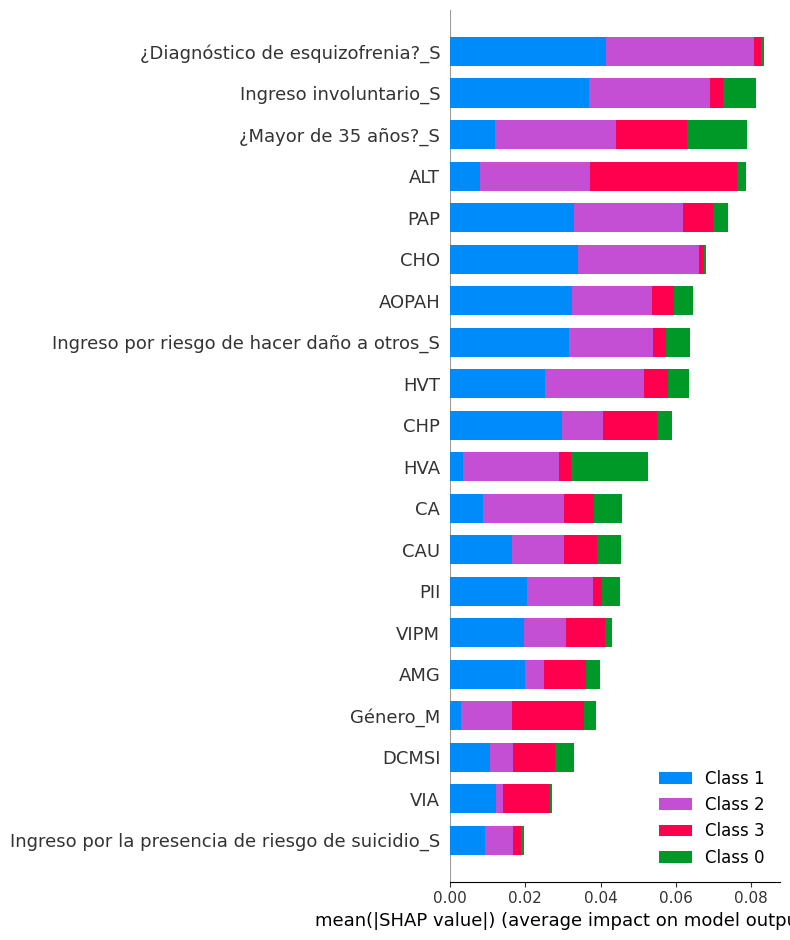

In [54]:
import shap

print("\n SHAP – Binary Neural Network (Grouped by Turno)")

background = X_dl[:100]
explainer_bin_turno = shap.KernelExplainer(model.predict, background)
shap_values_bin_turno = explainer_bin_turno.shap_values(X_dl[:10])

shap.summary_plot(shap_values_bin_turno, X_dl[:10], feature_names=X.columns)


 SHAP – Binary Neural Network (Grouped by Día)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 267us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step


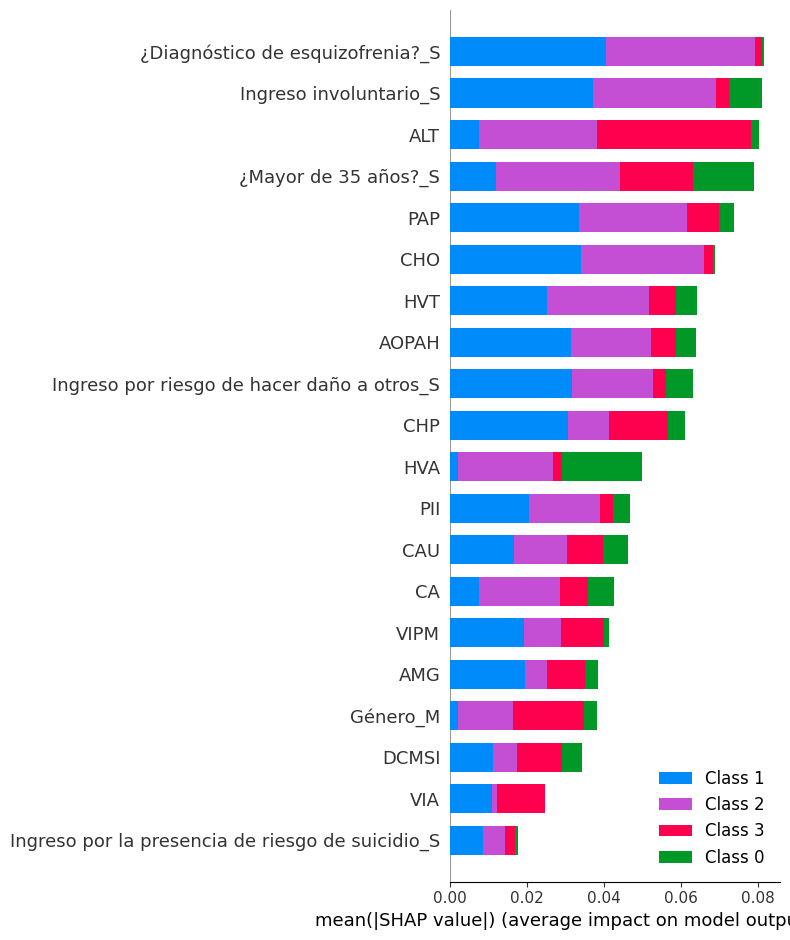

In [55]:
print("\n SHAP – Binary Neural Network (Grouped by Día)")

explainer_bin_day = shap.KernelExplainer(model.predict, X_dl[:100])
shap_values_bin_day = explainer_bin_day.shap_values(X_dl[:10])

shap.summary_plot(shap_values_bin_day, X_dl[:10], feature_names=X.columns)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 243us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 265us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 263us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 263us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step


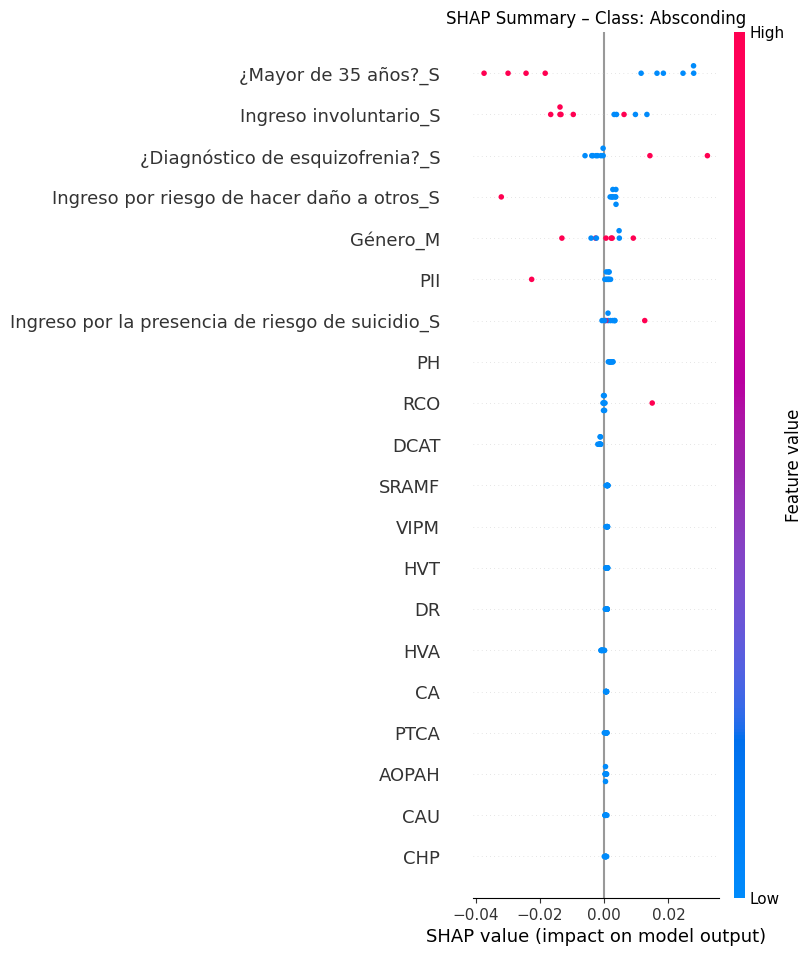

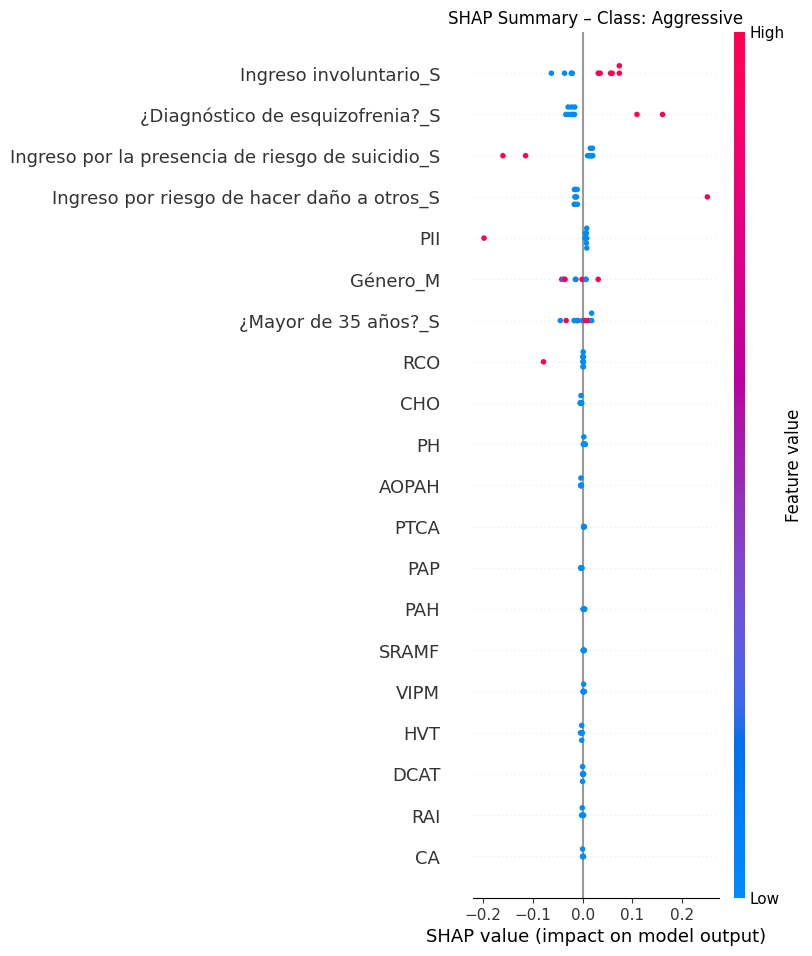

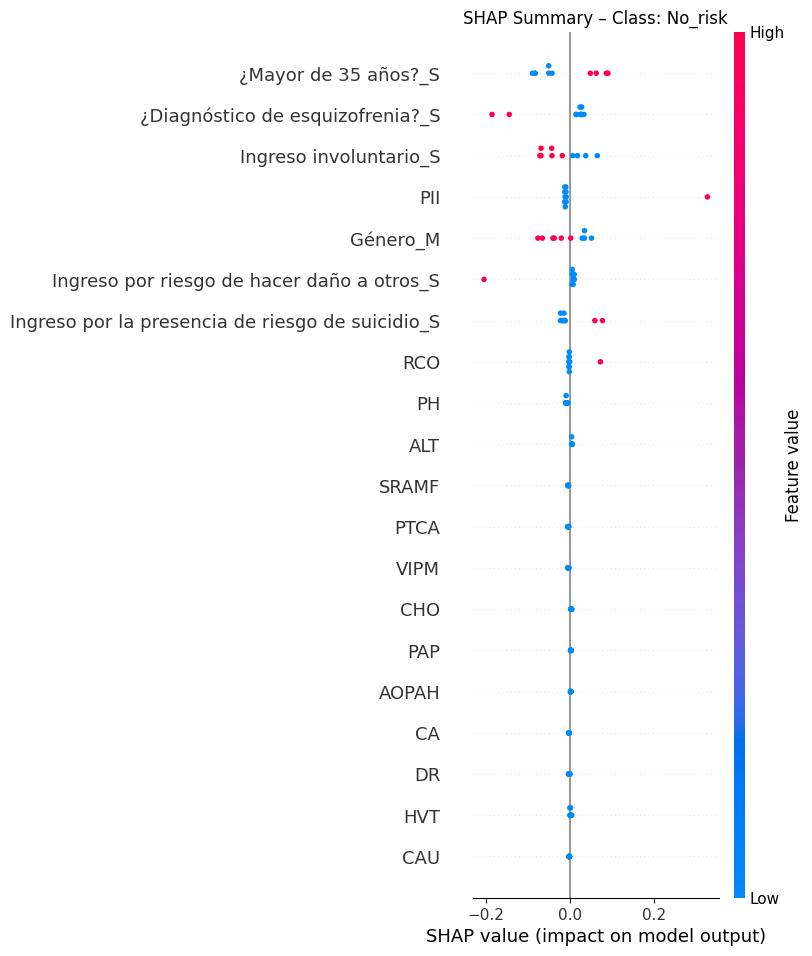

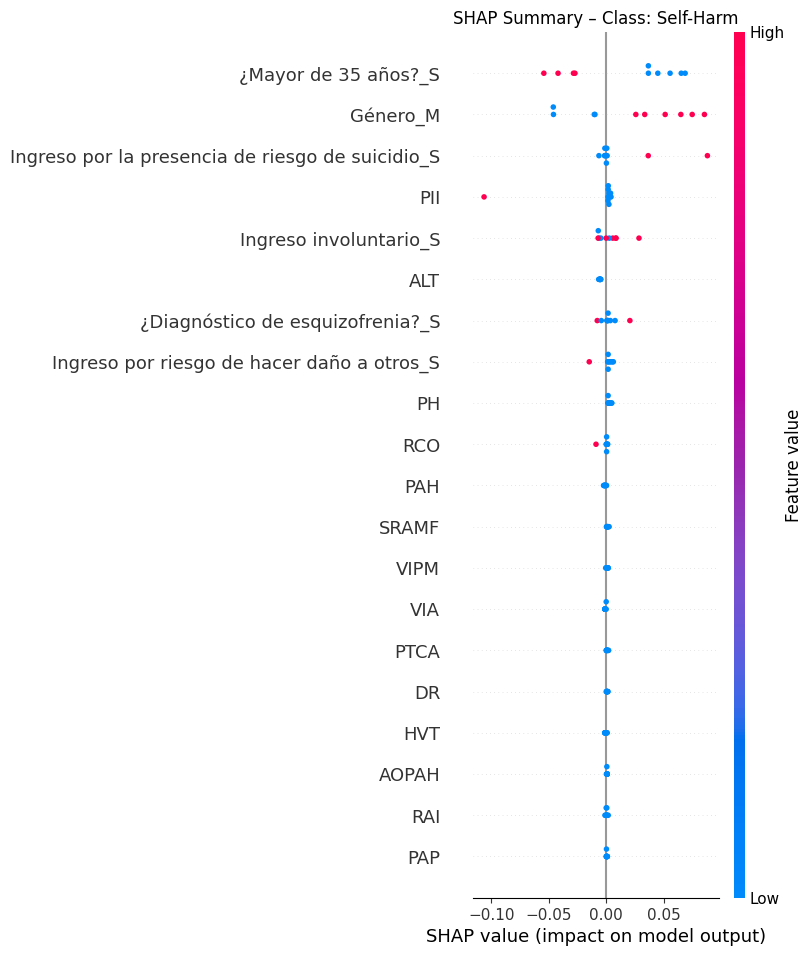

In [56]:
# Wrap model prediction
def model_predict(data):
    return model.predict(data)

# Background and sample data
background = X_mc_dl[np.random.choice(X_mc_dl.shape[0], 100, replace=False)]
sample = X_mc_dl[np.random.choice(X_mc_dl.shape[0], 10, replace=False)]

# KernelExplainer is model-agnostic
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(sample)

# Plot SHAP values for each class
for i, class_name in enumerate(labels_map.values()):
    shap.summary_plot(shap_values[i], sample, feature_names=X_mc.columns, 
                      show=False)  # Optional: show=False if running multiple
    plt.title(f"SHAP Summary – Class: {class_name}")
    plt.show()


 SHAP – Multiclass Neural Network (Grouped by Día)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 248us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step


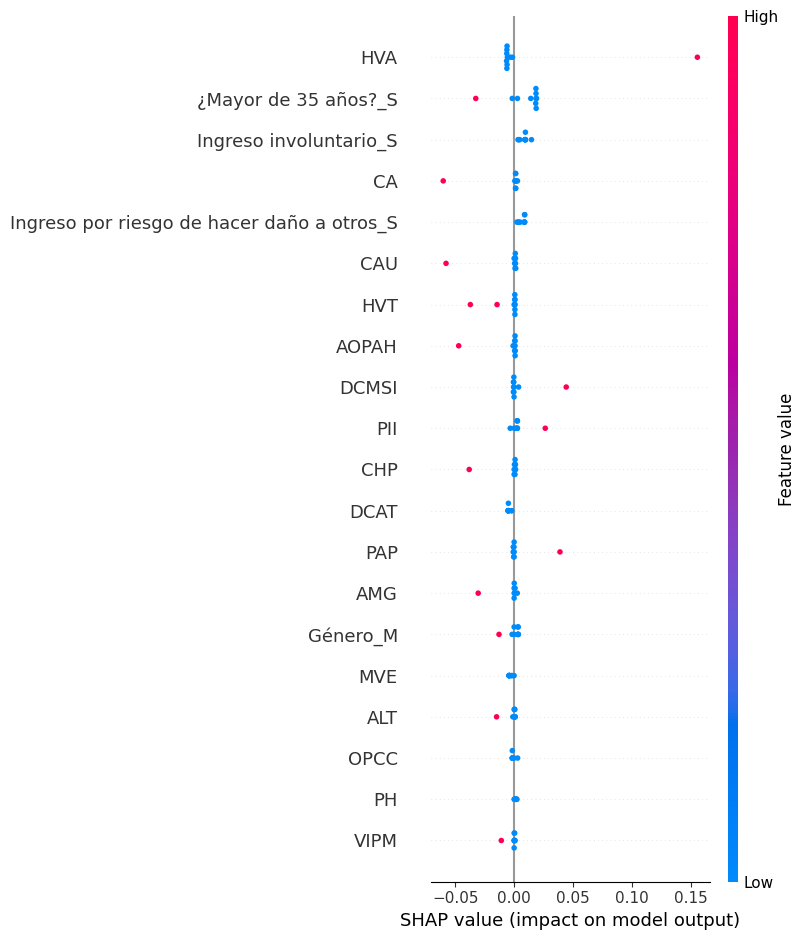

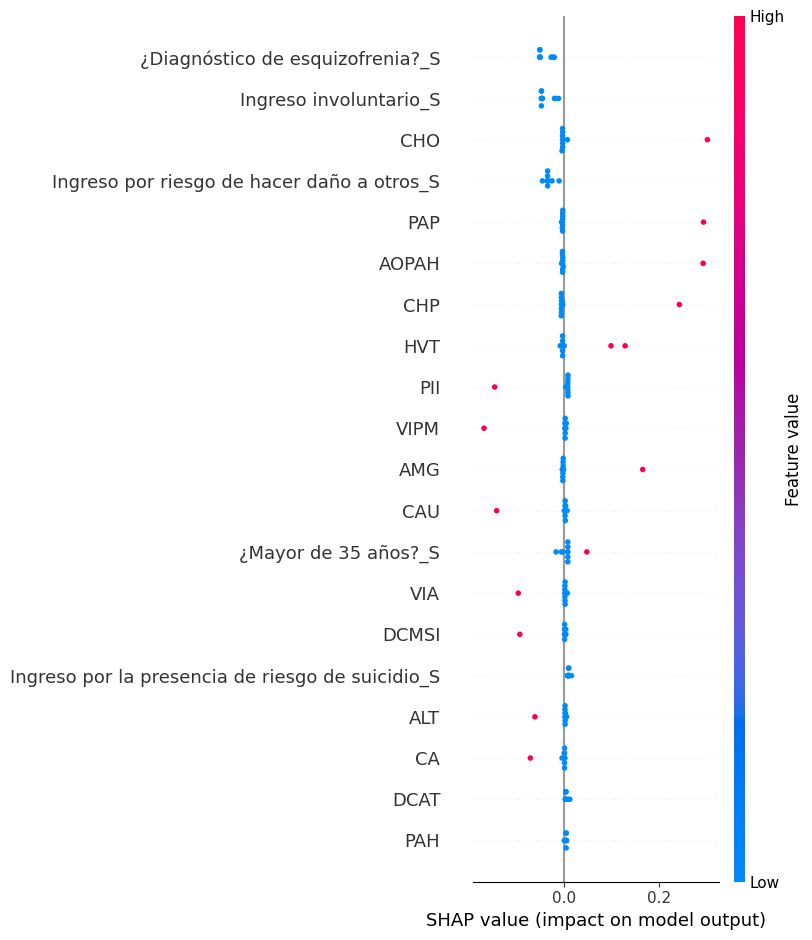

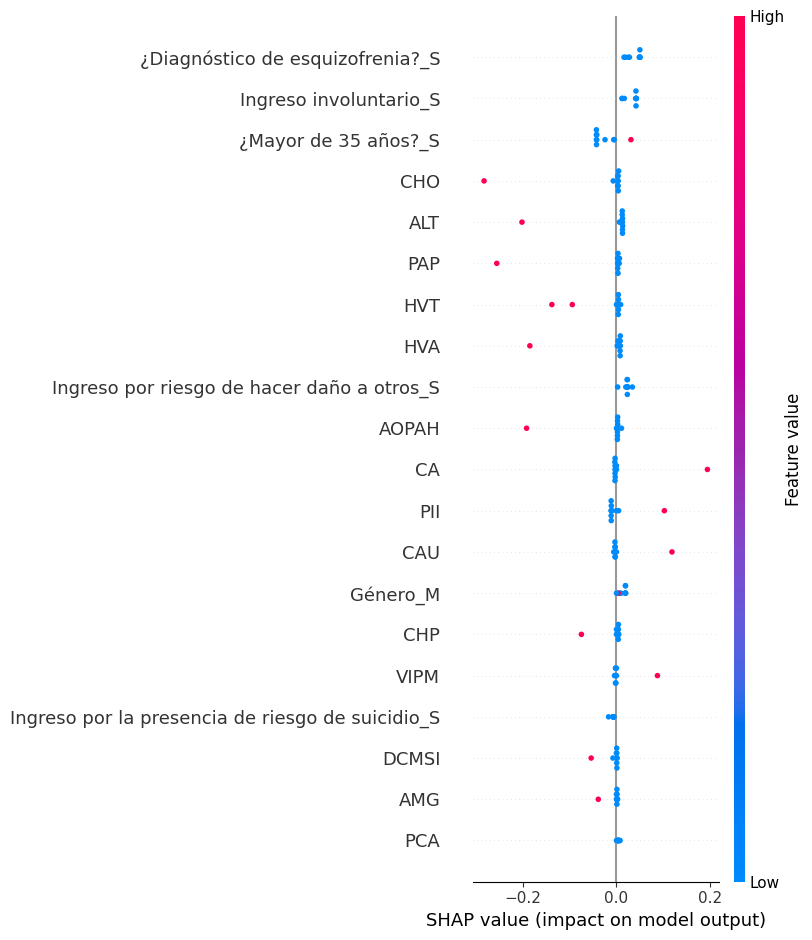

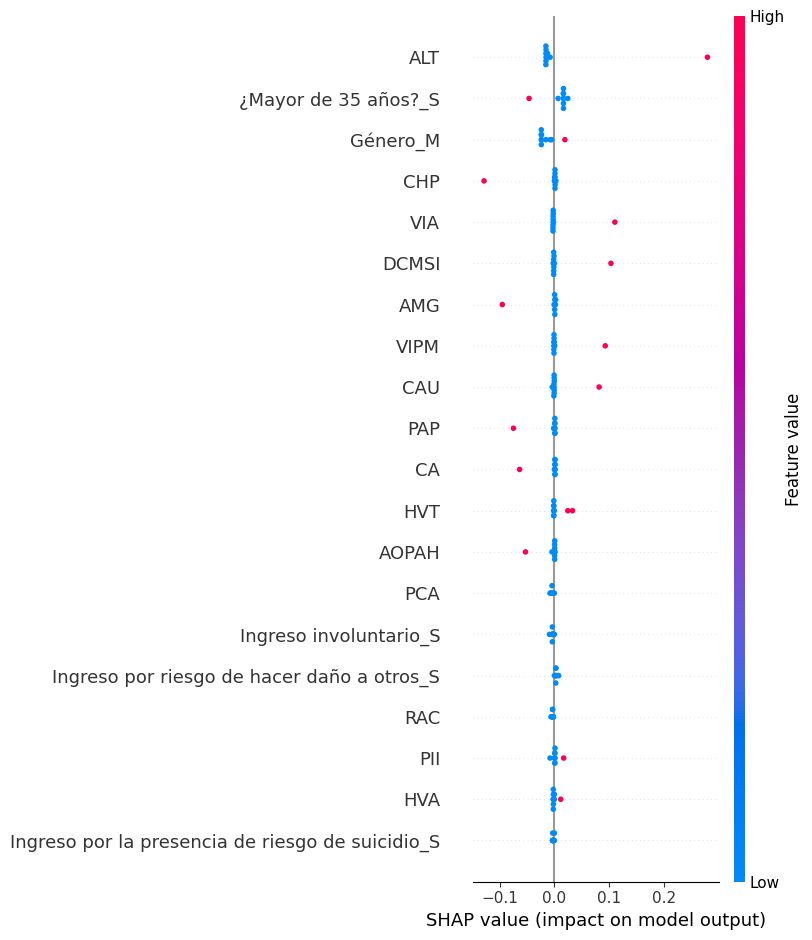

In [57]:
print("\n SHAP – Multiclass Neural Network (Grouped by Día)")

explainer_mc_day = shap.KernelExplainer(model.predict, X_mc_dl[:100])
shap_values_mc_day = explainer_mc_day.shap_values(X_mc_dl[:10])

for i, class_name in enumerate(labels_map.values()):
    shap.summary_plot(shap_values_mc_day[i], X_mc_dl[:10], feature_names=X_mc.columns, title=f"Class: {class_name}")

In [58]:
# Grid Search for Binary Classification (no grouping)

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

# Grid Search for Random Forest
rf_bin = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_params,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
rf_bin.fit(X_scaled, y)

# Hyperparameter grid for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
}

# Grid Search for XGBoost
xgb_bin = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_params,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
xgb_bin.fit(X_scaled, y)

print("Best parameters for Binary Random Forest:", rf_bin.best_params_)
print("Best parameters for Binary XGBoost:", xgb_bin.best_params_)

Best parameters for Binary Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for Binary XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [59]:
# Grid Search for Multiclass Classification
# Grid Search for multiclass Random Forest
rf_mc = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_params,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)
rf_mc.fit(X_mc_scaled, y_mc)

# Grid Search for multiclass XGBoost
xgb_mc = GridSearchCV(
    XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42),
    xgb_params,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)
xgb_mc.fit(X_mc_scaled, y_mc)

print("Best parameters for Multiclass Random Forest:", rf_mc.best_params_)
print("Best parameters for Multiclass XGBoost:", xgb_mc.best_params_)

Best parameters for Multiclass Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for Multiclass XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [60]:
# Grid Search with Leave-One-Group-Out (Binary by Day)

# Generic function to run Leave-One-Group-Out + Grid Search
def run_logo_grid(X_data, y_data, groups, model_class, param_grid, scoring='f1'):
    logo = LeaveOneGroupOut()
    scores = []

    for train_idx, test_idx in logo.split(X_data, y_data, groups):
        X_train, y_train = X_data[train_idx], y_data[train_idx]
        X_test, y_test = X_data[test_idx], y_data[test_idx]

        grid = GridSearchCV(model_class(), param_grid, cv=3, scoring=scoring, n_jobs=-1)
        grid.fit(X_train, y_train)
        preds = grid.best_estimator_.predict(X_test)
        
        if scoring == 'f1':
            score = f1_score(y_test, preds)
        elif scoring == 'f1_macro':
            score = f1_score(y_test, preds, average='macro')
        else:
            raise ValueError("Unsupported scoring method.")
        
        scores.append(score)

    return np.mean(scores)

# Run for binary by day
groups_by_day = df['Fecha']
print("Average F1 (RF, binary grouped by day):", run_logo_grid(X_scaled, y, groups_by_day, RandomForestClassifier, rf_params))
print("Average F1 (XGB, binary grouped by day):", run_logo_grid(X_scaled, y, groups_by_day, XGBClassifier, xgb_params))

Average F1 (RF, binary grouped by day): 0.2873949579831933
Average F1 (XGB, binary grouped by day): 0.2771241830065359


In [61]:
print("Average Macro F1 (RF, multiclass grouped by day):",
      run_logo_grid(X_mc_scaled, y_mc, groups_by_day_mc, RandomForestClassifier, rf_params, scoring='f1_macro'))

print("Average Macro F1 (XGB, multiclass grouped by day):",
      run_logo_grid(X_mc_scaled, y_mc, groups_by_day_mc, XGBClassifier, xgb_params, scoring='f1_macro'))

Average Macro F1 (RF, multiclass grouped by day): 0.7032835356364769
Average Macro F1 (XGB, multiclass grouped by day): 0.7001711795829443


In [62]:
# Use best params found by GridSearchCV for Random Forest
rf_best_params = rf_bin.best_params_
rf_optim = RandomForestClassifier(**rf_best_params, class_weight='balanced', random_state=42)

# Use best params found by GridSearchCV for XGBoost
xgb_best_params = xgb_bin.best_params_
xgb_optim = XGBClassifier(**xgb_best_params, eval_metric='logloss', random_state=42)

# LOPOCV
logo = LeaveOneGroupOut()

# --- Random Forest ---
y_true_rf_best, y_pred_rf_best = [], []
for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_optim.fit(X_train, y_train)
    y_pred = rf_optim.predict(X_test)

    y_true_rf_best.extend(y_test)
    y_pred_rf_best.extend(y_pred)

print("\n--- Random Forest (best params) – BINARY LOPOCV ---")
print(classification_report(y_true_rf_best, y_pred_rf_best, target_names=["No_Risk", "Risk"]))

# --- XGBoost ---
y_true_xgb_best, y_pred_xgb_best = [], []
for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_optim.fit(X_train, y_train)
    y_pred = xgb_optim.predict(X_test)

    y_true_xgb_best.extend(y_test)
    y_pred_xgb_best.extend(y_pred)

print("\n--- XGBoost (best params) – BINARY LOPOCV ---")
print(classification_report(y_true_xgb_best, y_pred_xgb_best, target_names=["No_Risk", "Risk"]))


--- Random Forest (best params) – BINARY LOPOCV ---
              precision    recall  f1-score   support

     No_Risk       0.70      0.81      0.75       415
        Risk       0.49      0.34      0.40       222

    accuracy                           0.65       637
   macro avg       0.59      0.57      0.57       637
weighted avg       0.62      0.65      0.63       637


--- XGBoost (best params) – BINARY LOPOCV ---
              precision    recall  f1-score   support

     No_Risk       0.68      0.85      0.75       415
        Risk       0.47      0.25      0.32       222

    accuracy                           0.64       637
   macro avg       0.57      0.55      0.54       637
weighted avg       0.60      0.64      0.60       637



In [63]:
# Best params for multiclass
rf_mc_best_params = rf_mc.best_params_
rf_mc_optim = RandomForestClassifier(**rf_mc_best_params, class_weight='balanced', random_state=42)

xgb_mc_best_params = xgb_mc.best_params_
xgb_mc_optim = XGBClassifier(**xgb_mc_best_params, objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42)

logo = LeaveOneGroupOut()

# --- Random Forest Multiclass ---
y_true_rf_mc_best, y_pred_rf_mc_best = [], []
for train_idx, test_idx in logo.split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]

    rf_mc_optim.fit(X_train, y_train)
    y_pred = rf_mc_optim.predict(X_test)

    y_true_rf_mc_best.extend(y_test)
    y_pred_rf_mc_best.extend(y_pred)

y_true_rf_mc_best_named = pd.Series(y_true_rf_mc_best).map(labels_map)
y_pred_rf_mc_best_named = pd.Series(y_pred_rf_mc_best).map(labels_map)
print("\n--- Random Forest (best params) – MULTICLASS LOPOCV ---")
print(classification_report(y_true_rf_mc_best_named, y_pred_rf_mc_best_named))

# --- XGBoost Multiclass ---
y_true_xgb_mc_best, y_pred_xgb_mc_best = [], []
for train_idx, test_idx in logo.split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]

    xgb_mc_optim.fit(X_train, y_train)
    y_pred = xgb_mc_optim.predict(X_test)

    y_true_xgb_mc_best.extend(y_test)
    y_pred_xgb_mc_best.extend(y_pred)

y_true_xgb_mc_best_named = pd.Series(y_true_xgb_mc_best).map(labels_map)
y_pred_xgb_mc_best_named = pd.Series(y_pred_xgb_mc_best).map(labels_map)
print("\n--- XGBoost (best params) – MULTICLASS LOPOCV ---")
print(classification_report(y_true_xgb_mc_best_named, y_pred_xgb_mc_best_named))


--- Random Forest (best params) – MULTICLASS LOPOCV ---
              precision    recall  f1-score   support

  Absconding       0.09      0.62      0.16        29
  Aggressive       0.48      0.36      0.41       162
     No_risk       0.85      0.53      0.65       415
   Self-Harm       0.43      0.74      0.54        31

    accuracy                           0.50       637
   macro avg       0.46      0.56      0.44       637
weighted avg       0.70      0.50      0.56       637


--- XGBoost (best params) – MULTICLASS LOPOCV ---
              precision    recall  f1-score   support

  Absconding       0.00      0.00      0.00        29
  Aggressive       0.43      0.25      0.31       162
     No_risk       0.68      0.85      0.75       415
   Self-Harm       0.04      0.03      0.04        31

    accuracy                           0.62       637
   macro avg       0.29      0.28      0.28       637
weighted avg       0.55      0.62      0.57       637



In [64]:
# Binary Random Forest
acc_rf = accuracy_score(y_true_rf_best, y_pred_rf_best)
print("Random Forest (best params) Binary LOPOCV Accuracy:", acc_rf)

# Binary XGBoost
acc_xgb = accuracy_score(y_true_xgb_best, y_pred_xgb_best)
print("XGBoost (best params) Binary LOPOCV Accuracy:", acc_xgb)

# Multiclass Random Forest
acc_rf_mc = accuracy_score(y_true_rf_mc_best, y_pred_rf_mc_best)
print("Random Forest (best params) Multiclass LOPOCV Accuracy:", acc_rf_mc)

# Multiclass XGBoost
acc_xgb_mc = accuracy_score(y_true_xgb_mc_best, y_pred_xgb_mc_best)
print("XGBoost (best params) Multiclass LOPOCV Accuracy:", acc_xgb_mc)

Random Forest (best params) Binary LOPOCV Accuracy: 0.6467817896389325
XGBoost (best params) Binary LOPOCV Accuracy: 0.6389324960753532
Random Forest (best params) Multiclass LOPOCV Accuracy: 0.5039246467817896
XGBoost (best params) Multiclass LOPOCV Accuracy: 0.6153846153846154


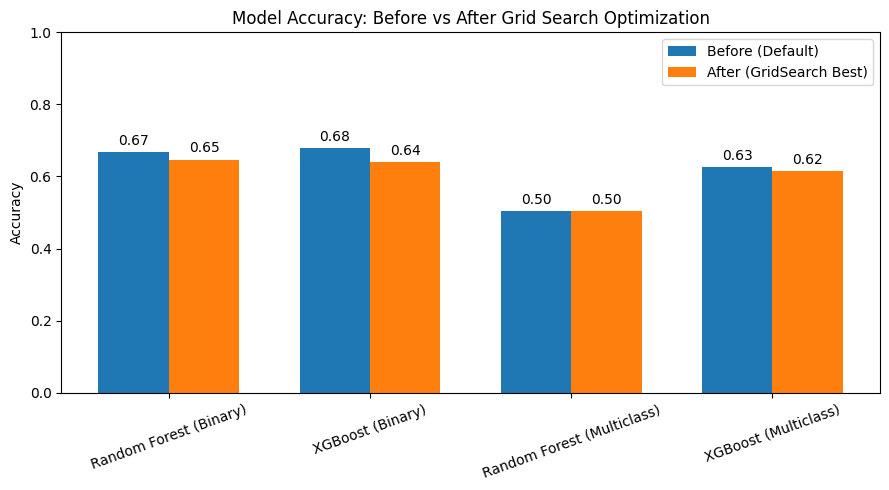

In [65]:
# Compute accuracies (BEFORE)
acc_rf_before = accuracy_score(y_true_rf, y_pred_rf)
acc_xgb_before = accuracy_score(y_true_xgb, y_pred_xgb)
acc_rf_mc_before = accuracy_score(y_true_mc_rf, y_pred_mc_rf)
acc_xgb_mc_before = accuracy_score(y_true_mc_xgb, y_pred_mc_xgb)

# Compute accuracies (AFTER GRID SEARCH)
acc_rf_after = accuracy_score(y_true_rf_best, y_pred_rf_best)
acc_xgb_after = accuracy_score(y_true_xgb_best, y_pred_xgb_best)
acc_rf_mc_after = accuracy_score(y_true_rf_mc_best, y_pred_rf_mc_best)
acc_xgb_mc_after = accuracy_score(y_true_xgb_mc_best, y_pred_xgb_mc_best)

labels = [
    'Random Forest (Binary)',
    'XGBoost (Binary)',
    'Random Forest (Multiclass)',
    'XGBoost (Multiclass)'
]
acc_before = [acc_rf_before, acc_xgb_before, acc_rf_mc_before, acc_xgb_mc_before]
acc_after = [acc_rf_after, acc_xgb_after, acc_rf_mc_after, acc_xgb_mc_after]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(x - width/2, acc_before, width, label='Before (Default)')
bars2 = ax.bar(x + width/2, acc_after, width, label='After (GridSearch Best)')

ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy: Before vs After Grid Search Optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20)
ax.set_ylim(0, 1)
ax.legend()

# Annotate values above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [66]:
# For binary classification
print("Binary class balance:")
print(pd.Series(y).value_counts(normalize=True))

# For multiclass
print("Multiclass class balance:")
print(pd.Series(y_mc).value_counts(normalize=True))

Binary class balance:
Risk_Binary
0    0.651491
1    0.348509
Name: proportion, dtype: float64
Multiclass class balance:
2    0.651491
1    0.254317
3    0.048666
0    0.045526
Name: proportion, dtype: float64


In [67]:
from sklearn.metrics import classification_report

print("--- Random Forest Binary (Default) ---")
print(classification_report(y_true_rf, y_pred_rf, target_names=["No_Risk", "Risk"]))

print("--- Random Forest Binary (GridSearch Best) ---")
print(classification_report(y_true_rf_best, y_pred_rf_best, target_names=["No_Risk", "Risk"]))

print("--- XGBoost Binary (Default) ---")
print(classification_report(y_true_xgb, y_pred_xgb, target_names=["No_Risk", "Risk"]))

print("--- XGBoost Binary (GridSearch Best) ---")
print(classification_report(y_true_xgb_best, y_pred_xgb_best, target_names=["No_Risk", "Risk"]))

--- Random Forest Binary (Default) ---
              precision    recall  f1-score   support

     No_Risk       0.72      0.81      0.76       415
        Risk       0.53      0.40      0.45       222

    accuracy                           0.67       637
   macro avg       0.62      0.61      0.61       637
weighted avg       0.65      0.67      0.66       637

--- Random Forest Binary (GridSearch Best) ---
              precision    recall  f1-score   support

     No_Risk       0.70      0.81      0.75       415
        Risk       0.49      0.34      0.40       222

    accuracy                           0.65       637
   macro avg       0.59      0.57      0.57       637
weighted avg       0.62      0.65      0.63       637

--- XGBoost Binary (Default) ---
              precision    recall  f1-score   support

     No_Risk       0.73      0.81      0.77       415
        Risk       0.55      0.44      0.49       222

    accuracy                           0.68       637
   macro 

In [68]:
print("Random Forest Binary GridSearch best params:", rf_bin.best_params_)
print("XGBoost Binary GridSearch best params:", xgb_bin.best_params_)
print("Random Forest Multiclass GridSearch best params:", rf_mc.best_params_)
print("XGBoost Multiclass GridSearch best params:", xgb_mc.best_params_)

Random Forest Binary GridSearch best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
XGBoost Binary GridSearch best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Random Forest Multiclass GridSearch best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
XGBoost Multiclass GridSearch best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


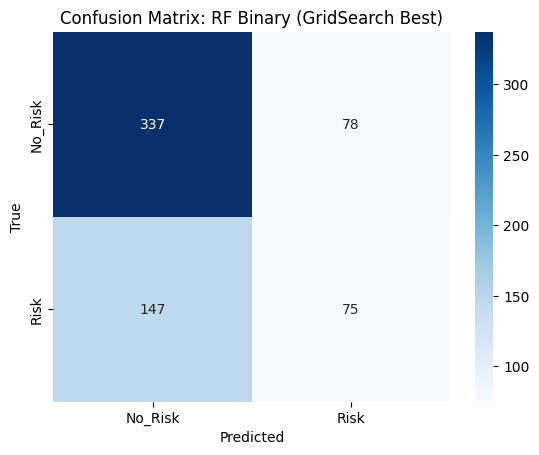

In [69]:
import seaborn as sns

cm = confusion_matrix(y_true_rf_best, y_pred_rf_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No_Risk", "Risk"], yticklabels=["No_Risk", "Risk"])
plt.title("Confusion Matrix: RF Binary (GridSearch Best)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [70]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Ejemplo forzando el warning
y_true = []
y_pred = []
print(f1_score(y_true, y_pred))

0.0


Best RF params with LOPOCV (binary): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best XGB params with LOPOCV (binary): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy RF binary (LOPOCV): 0.6687598116169545
Accuracy XGB binary (LOPOCV): 0.6781789638932496
Best RF params with LOPOCV (multiclass): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best XGB params with LOPOCV (multiclass): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Accuracy RF multiclass (LOPOCV): 0.45054945054945056
Accuracy XGB multiclass (LOPOCV): 0.6514913657770801


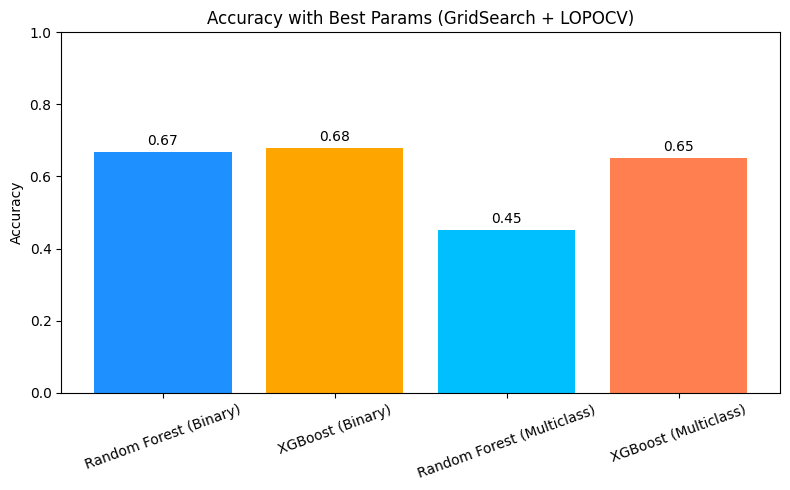

In [71]:
# 1. LOPOCV SPLITTER
logo = LeaveOneGroupOut()

# 2. PARAMETER GRIDS
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
}

# ========== BINARY CLASSIFICATION ==========

# -- RANDOM FOREST (BINARY, LOPOCV + GRIDSEARCH)
rf_logo_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_params,
    cv=logo.split(X_scaled, y, groups),   # Leave-One-Group-Out for validation
    scoring='f1',
    n_jobs=-1
)
rf_logo_grid.fit(X_scaled, y)
rf_best_params = rf_logo_grid.best_params_
print("Best RF params with LOPOCV (binary):", rf_best_params)

# -- XGBOOST (BINARY, LOPOCV + GRIDSEARCH)
xgb_logo_grid = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_params,
    cv=logo.split(X_scaled, y, groups),
    scoring='f1',
    n_jobs=-1
)
xgb_logo_grid.fit(X_scaled, y)
xgb_best_params = xgb_logo_grid.best_params_
print("Best XGB params with LOPOCV (binary):", xgb_best_params)

# -- EVALUATE MODELS WITH BEST HYPERPARAMETERS
# Random Forest
rf_final = RandomForestClassifier(**rf_best_params, class_weight='balanced', random_state=42)
y_true_rf, y_pred_rf = [], []
for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_final.fit(X_train, y_train)
    y_pred = rf_final.predict(X_test)
    y_true_rf.extend(y_test)
    y_pred_rf.extend(y_pred)

acc_rf = accuracy_score(y_true_rf, y_pred_rf)
print("Accuracy RF binary (LOPOCV):", acc_rf)

# XGBoost
xgb_final = XGBClassifier(**xgb_best_params, eval_metric='logloss', random_state=42)
y_true_xgb, y_pred_xgb = [], []
for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    xgb_final.fit(X_train, y_train)
    y_pred = xgb_final.predict(X_test)
    y_true_xgb.extend(y_test)
    y_pred_xgb.extend(y_pred)

acc_xgb = accuracy_score(y_true_xgb, y_pred_xgb)
print("Accuracy XGB binary (LOPOCV):", acc_xgb)

# ========== MULTICLASS CLASSIFICATION ==========

# -- RANDOM FOREST (MULTICLASS, LOPOCV + GRIDSEARCH)
rf_logo_grid_mc = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_params,
    cv=logo.split(X_mc_scaled, y_mc, groups_mc),
    scoring='f1_macro',
    n_jobs=-1
)
rf_logo_grid_mc.fit(X_mc_scaled, y_mc)
rf_best_params_mc = rf_logo_grid_mc.best_params_
print("Best RF params with LOPOCV (multiclass):", rf_best_params_mc)

# -- XGBOOST (MULTICLASS, LOPOCV + GRIDSEARCH)
xgb_logo_grid_mc = GridSearchCV(
    XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42),
    xgb_params,
    cv=logo.split(X_mc_scaled, y_mc, groups_mc),
    scoring='f1_macro',
    n_jobs=-1
)
xgb_logo_grid_mc.fit(X_mc_scaled, y_mc)
xgb_best_params_mc = xgb_logo_grid_mc.best_params_
print("Best XGB params with LOPOCV (multiclass):", xgb_best_params_mc)

# -- EVALUATE MODELS WITH BEST HYPERPARAMETERS (MULTICLASS)
# Random Forest
rf_final_mc = RandomForestClassifier(**rf_best_params_mc, class_weight='balanced', random_state=42)
y_true_rf_mc, y_pred_rf_mc = [], []
for train_idx, test_idx in logo.split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]
    rf_final_mc.fit(X_train, y_train)
    y_pred = rf_final_mc.predict(X_test)
    y_true_rf_mc.extend(y_test)
    y_pred_rf_mc.extend(y_pred)

acc_rf_mc = accuracy_score(y_true_rf_mc, y_pred_rf_mc)
print("Accuracy RF multiclass (LOPOCV):", acc_rf_mc)

# XGBoost
xgb_final_mc = XGBClassifier(**xgb_best_params_mc, objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42)
y_true_xgb_mc, y_pred_xgb_mc = [], []
for train_idx, test_idx in logo.split(X_mc_scaled, y_mc, groups_mc):
    X_train, X_test = X_mc_scaled[train_idx], X_mc_scaled[test_idx]
    y_train, y_test = y_mc[train_idx], y_mc[test_idx]
    xgb_final_mc.fit(X_train, y_train)
    y_pred = xgb_final_mc.predict(X_test)
    y_true_xgb_mc.extend(y_test)
    y_pred_xgb_mc.extend(y_pred)

acc_xgb_mc = accuracy_score(y_true_xgb_mc, y_pred_xgb_mc)
print("Accuracy XGB multiclass (LOPOCV):", acc_xgb_mc)

# ========== BARPLOT ==========

labels = [
    'Random Forest (Binary)',
    'XGBoost (Binary)',
    'Random Forest (Multiclass)',
    'XGBoost (Multiclass)'
]
accuracies = [acc_rf, acc_xgb, acc_rf_mc, acc_xgb_mc]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, accuracies, color=['dodgerblue','orange','deepskyblue','coral'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy with Best Params (GridSearch + LOPOCV)")
plt.xticks(rotation=20)

# Annotate values on top of bars
for bar in bars:
    plt.annotate(f"{bar.get_height():.2f}", xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0,3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [72]:
def get_binary_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Risk)': precision_score(y_true, y_pred),
        'Recall (Risk)': recall_score(y_true, y_pred),
        'F1 (Risk)': f1_score(y_true, y_pred)
    }

# Compile metrics (existing models)
summary_bin = pd.DataFrame([
    get_binary_metrics(y_true_logreg, y_pred_logreg, 'Logistic Regression'),
    get_binary_metrics(y_true_rf, y_pred_rf, 'Random Forest'),
    get_binary_metrics(y_true_xgb, y_pred_xgb, 'XGBoost'),
    get_binary_metrics(y_true_nn, y_pred_nn, 'Neural Network')
])

# Print summary
print("\n--- Binary Classification Summary Table ---")
print(summary_bin)


--- Binary Classification Summary Table ---
                 Model  Accuracy  Precision (Risk)  Recall (Risk)  F1 (Risk)
0  Logistic Regression  0.653061          0.502463       0.459459   0.480000
1        Random Forest  0.668760          0.533333       0.396396   0.454780
2              XGBoost  0.678179          0.559441       0.360360   0.438356
3       Neural Network  0.618524          0.403670       0.198198   0.265861


In [73]:
# Helper function for macro metrics
def get_multiclass_metrics(y_true, y_pred, model_name, label_map):
    y_true_named = pd.Series(y_true).map(label_map)
    y_pred_named = pd.Series(y_pred).map(label_map)
    report = classification_report(y_true_named, y_pred_named, output_dict=True)
    return {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1': report['macro avg']['f1-score']
    }

# Compile metrics
summary_mc = pd.DataFrame([
    get_multiclass_metrics(y_true_mc_log, y_pred_mc_log, 'Logistic Regression', labels_map),
    get_multiclass_metrics(y_true_mc_rf, y_pred_mc_rf, 'Random Forest', labels_map),
    get_multiclass_metrics(y_true_mc_xgb, y_pred_mc_xgb, 'XGBoost', labels_map)
])

print("\n--- Multiclass Classification Summary Table ---")
print(summary_mc)


--- Multiclass Classification Summary Table ---
                 Model  Accuracy  Macro Precision  Macro Recall  Macro F1
0  Logistic Regression  0.387755         0.329239      0.388636  0.292583
1        Random Forest  0.503925         0.460699      0.564838  0.441738
2              XGBoost  0.626374         0.295756      0.285456  0.279705


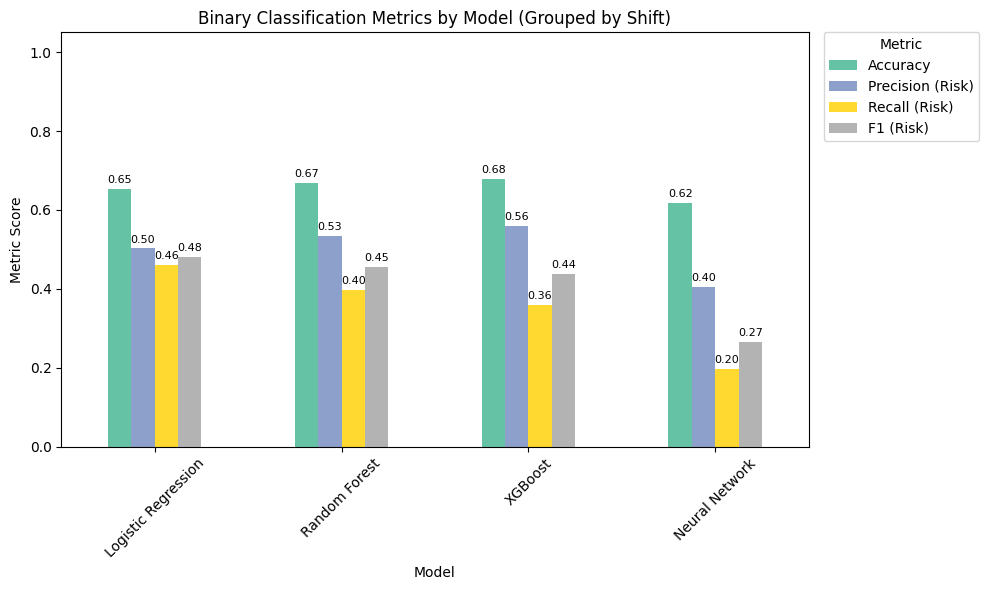

In [74]:
# Append Neural Network to summary_bin if not already included
if 'Neural Network' not in summary_bin['Model'].values:
    summary_bin = pd.concat([
        summary_bin,
        pd.DataFrame([get_binary_metrics(y_true_nn, y_pred_nn, 'Neural Network')])
    ], ignore_index=True)

# Set model as index
summary_bin_plot = summary_bin.set_index('Model')
metrics_to_plot = ['Accuracy', 'Precision (Risk)', 'Recall (Risk)', 'F1 (Risk)']

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
summary_bin_plot[metrics_to_plot].plot(kind='bar', ax=ax, colormap='Set2')

# Titles and labels in English
ax.set_title('Binary Classification Metrics by Model (Grouped by Shift)')
ax.set_ylabel('Metric Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1.05)
ax.set_xticklabels(summary_bin_plot.index, rotation=45)

# Annotate values above bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height + 0.01),
                ha='center', va='bottom', fontsize=8)

# Move legend outside the plot
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

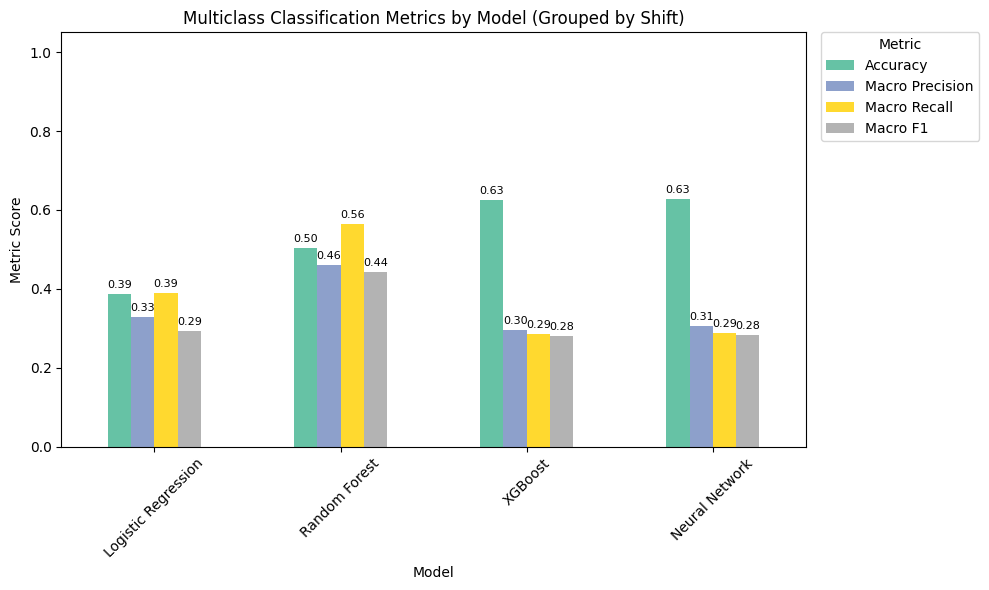

In [75]:

def get_multiclass_metrics(y_true, y_pred, model_name, label_map):
    y_true_series = pd.Series(y_true)
    y_pred_series = pd.Series(y_pred)

    # Only map if values are numeric (e.g., 0, 1, 2)
    if pd.api.types.is_numeric_dtype(y_true_series):
        y_true_named = y_true_series.map(label_map)
        y_pred_named = y_pred_series.map(label_map)
    else:
        y_true_named = y_true_series
        y_pred_named = y_pred_series

    # Compute classification report
    report = classification_report(y_true_named, y_pred_named, output_dict=True)

    # Return summary metrics
    return {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1': report['macro avg']['f1-score']
    }

# Build the summary_mc DataFrame with 3 models + NN
summary_mc = pd.DataFrame([
    get_multiclass_metrics(y_true_mc_log, y_pred_mc_log, 'Logistic Regression', labels_map),
    get_multiclass_metrics(y_true_mc_rf, y_pred_mc_rf, 'Random Forest', labels_map),
    get_multiclass_metrics(y_true_mc_xgb, y_pred_mc_xgb, 'XGBoost', labels_map)
])

# Add Neural Network if not present
if 'Neural Network' not in summary_mc['Model'].values:
    summary_mc = pd.concat([
        summary_mc,
        pd.DataFrame([
            get_multiclass_metrics(y_true_named_turno, y_pred_named_turno, 'Neural Network', labels_map)
        ])
    ], ignore_index=True)

# Plotting
summary_mc_plot = summary_mc.set_index('Model')
metrics_to_plot = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']

fig, ax = plt.subplots(figsize=(10, 6))
summary_mc_plot[metrics_to_plot].plot(kind='bar', ax=ax, colormap='Set2')

# Style
ax.set_title('Multiclass Classification Metrics by Model (Grouped by Shift)')
ax.set_ylabel('Metric Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1.05)
ax.set_xticklabels(summary_mc_plot.index, rotation=45)

# Annotate values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height + 0.01),
                ha='center', va='bottom', fontsize=8)

# Legend
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

In [76]:
# Binary classification metrics
def get_binary_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Risk)': precision_score(y_true, y_pred),
        'Recall (Risk)': recall_score(y_true, y_pred),
        'F1 (Risk)': f1_score(y_true, y_pred)
    }

# Multiclass classification metrics (safe mapping)
def get_multiclass_metrics(y_true, y_pred, model_name, label_map):
    y_true_series = pd.Series(y_true)
    y_pred_series = pd.Series(y_pred)

    if pd.api.types.is_numeric_dtype(y_true_series):
        y_true_named = y_true_series.map(label_map)
        y_pred_named = y_pred_series.map(label_map)
    else:
        y_true_named = y_true_series
        y_pred_named = y_pred_series

    report = classification_report(y_true_named, y_pred_named, output_dict=True)
    return {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1': report['macro avg']['f1-score']
    }

In [77]:
# Binary metrics grouped by day
summary_day_bin = pd.DataFrame([
    get_binary_metrics(results_by_day["Logistic Regression"]['y_true'],
                       results_by_day["Logistic Regression"]['y_pred'],
                       "Logistic Regression"),
    get_binary_metrics(results_by_day["Random Forest"]['y_true'],
                       results_by_day["Random Forest"]['y_pred'],
                       "Random Forest"),
    get_binary_metrics(results_by_day["XGBoost"]['y_true'],
                       results_by_day["XGBoost"]['y_pred'],
                       "XGBoost"),
    get_binary_metrics(y_true_nn_day, y_pred_nn_day, "Neural Network")
])

In [78]:
# Multiclass metrics grouped by day
summary_day_mc = pd.DataFrame([
    get_multiclass_metrics(results_mc_by_day["Logistic Regression"]['y_true'],
                           results_mc_by_day["Logistic Regression"]['y_pred'],
                           "Logistic Regression", labels_map),
    get_multiclass_metrics(results_mc_by_day["Random Forest"]['y_true'],
                           results_mc_by_day["Random Forest"]['y_pred'],
                           "Random Forest", labels_map),
    get_multiclass_metrics(results_mc_by_day["XGBoost"]['y_true'],
                           results_mc_by_day["XGBoost"]['y_pred'],
                           "XGBoost", labels_map),
    get_multiclass_metrics(y_true_named_day, y_pred_named_day,
                           "Neural Network", labels_map)
])

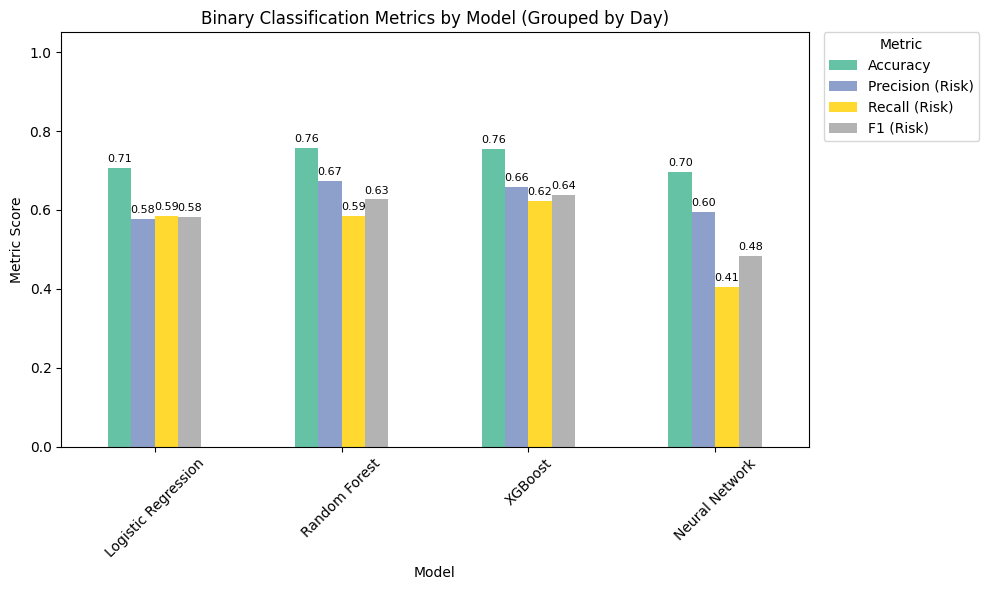

In [79]:
# Set 'Model' as index
summary_day_bin_plot = summary_day_bin.set_index('Model')
metrics_bin = ['Accuracy', 'Precision (Risk)', 'Recall (Risk)', 'F1 (Risk)']

fig, ax = plt.subplots(figsize=(10, 6))
summary_day_bin_plot[metrics_bin].plot(kind='bar', ax=ax, colormap='Set2')

# Titles and labels
ax.set_title('Binary Classification Metrics by Model (Grouped by Day)')
ax.set_ylabel('Metric Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1.05)
ax.set_xticklabels(summary_day_bin_plot.index, rotation=45)

# Annotate values above bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height + 0.01),
                ha='center', va='bottom', fontsize=8)

# Legend
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

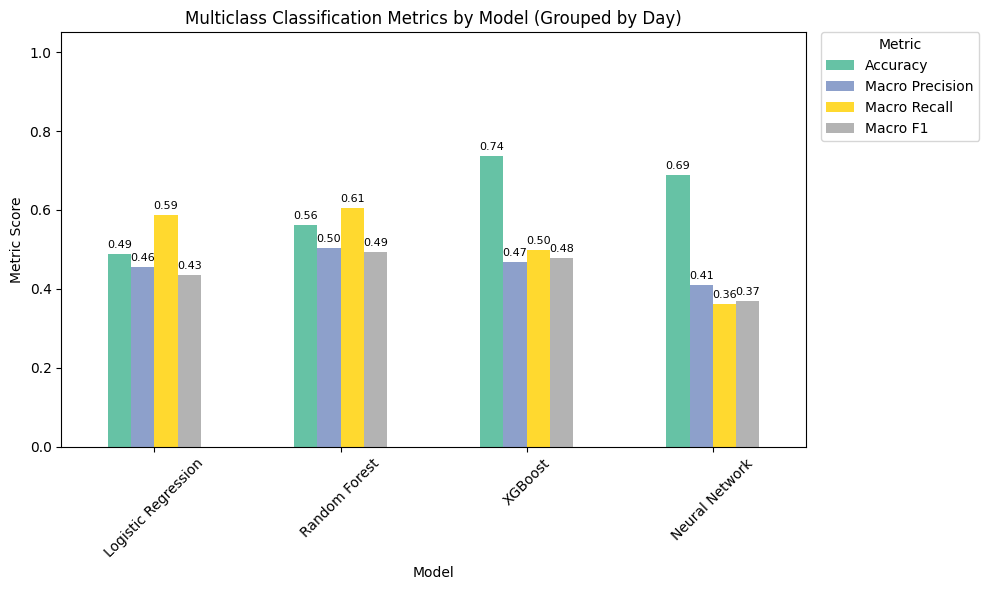

In [80]:
# Set 'Model' as index
summary_day_mc_plot = summary_day_mc.set_index('Model')
metrics_mc = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']

fig, ax = plt.subplots(figsize=(10, 6))
summary_day_mc_plot[metrics_mc].plot(kind='bar', ax=ax, colormap='Set2')

# Titles and labels in English
ax.set_title('Multiclass Classification Metrics by Model (Grouped by Day)')
ax.set_ylabel('Metric Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1.05)
ax.set_xticklabels(summary_day_mc_plot.index, rotation=45)

# Annotate values above bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height + 0.01),
                ha='center', va='bottom', fontsize=8)

# Legend
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

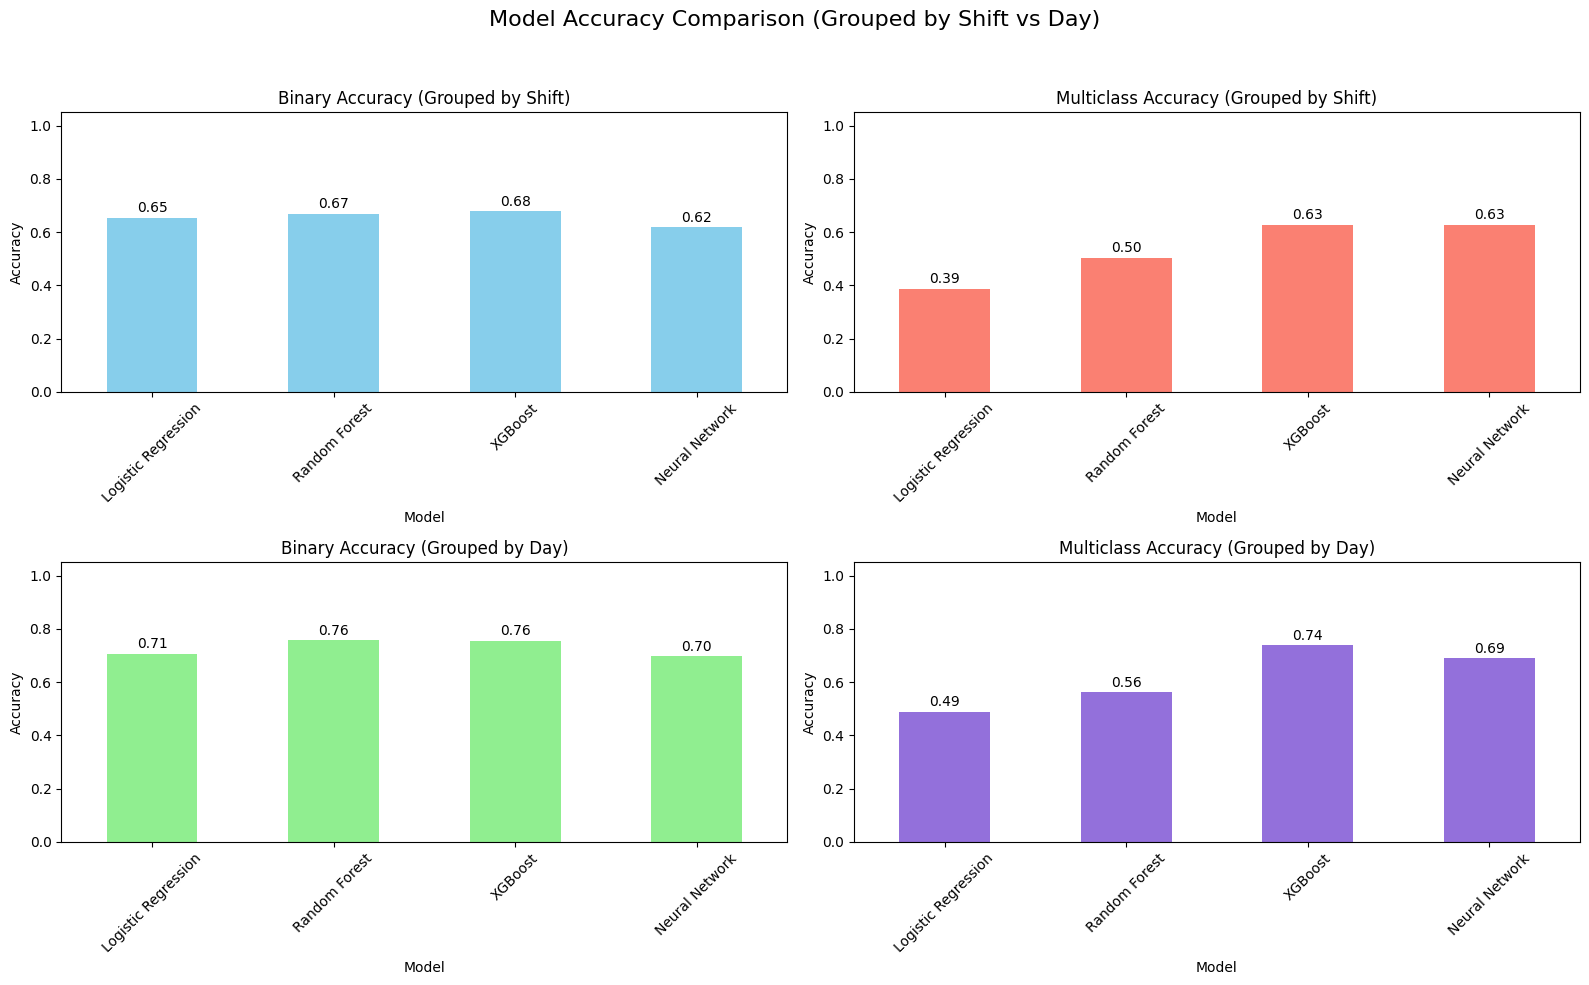

In [81]:
# Helper: Extract accuracy series from summary DataFrame
def get_accuracy_series(summary_df):
    return summary_df.set_index('Model')['Accuracy']

# Extract accuracy values from all four summary tables
acc_bin_shift = get_accuracy_series(summary_bin)         # Binary - Grouped by Shift
acc_mc_shift = get_accuracy_series(summary_mc)           # Multiclass - Grouped by Shift
acc_bin_day = get_accuracy_series(summary_day_bin)       # Binary - Grouped by Day
acc_mc_day = get_accuracy_series(summary_day_mc)         # Multiclass - Grouped by Day

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Accuracy Comparison (Grouped by Shift vs Day)', fontsize=16)

# Top-left: Binary Accuracy (Shift)
acc_bin_shift.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Binary Accuracy (Grouped by Shift)')
axes[0, 0].set_ylim(0, 1.05)
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width()/2., p.get_height() + 0.01),
                        ha='center', va='bottom')

# Top-right: Multiclass Accuracy (Shift)
acc_mc_shift.plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Multiclass Accuracy (Grouped by Shift)')
axes[0, 1].set_ylim(0, 1.05)
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width()/2., p.get_height() + 0.01),
                        ha='center', va='bottom')

# Bottom-left: Binary Accuracy (Day)
acc_bin_day.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Binary Accuracy (Grouped by Day)')
axes[1, 0].set_ylim(0, 1.05)
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width()/2., p.get_height() + 0.01),
                        ha='center', va='bottom')

# Bottom-right: Multiclass Accuracy (Day)
acc_mc_day.plot(kind='bar', ax=axes[1, 1], color='mediumpurple')
axes[1, 1].set_title('Multiclass Accuracy (Grouped by Day)')
axes[1, 1].set_ylim(0, 1.05)
for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width()/2., p.get_height() + 0.01),
                        ha='center', va='bottom')

# Common layout formatting
for ax in axes.flatten():
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [82]:
!pip install seaborn

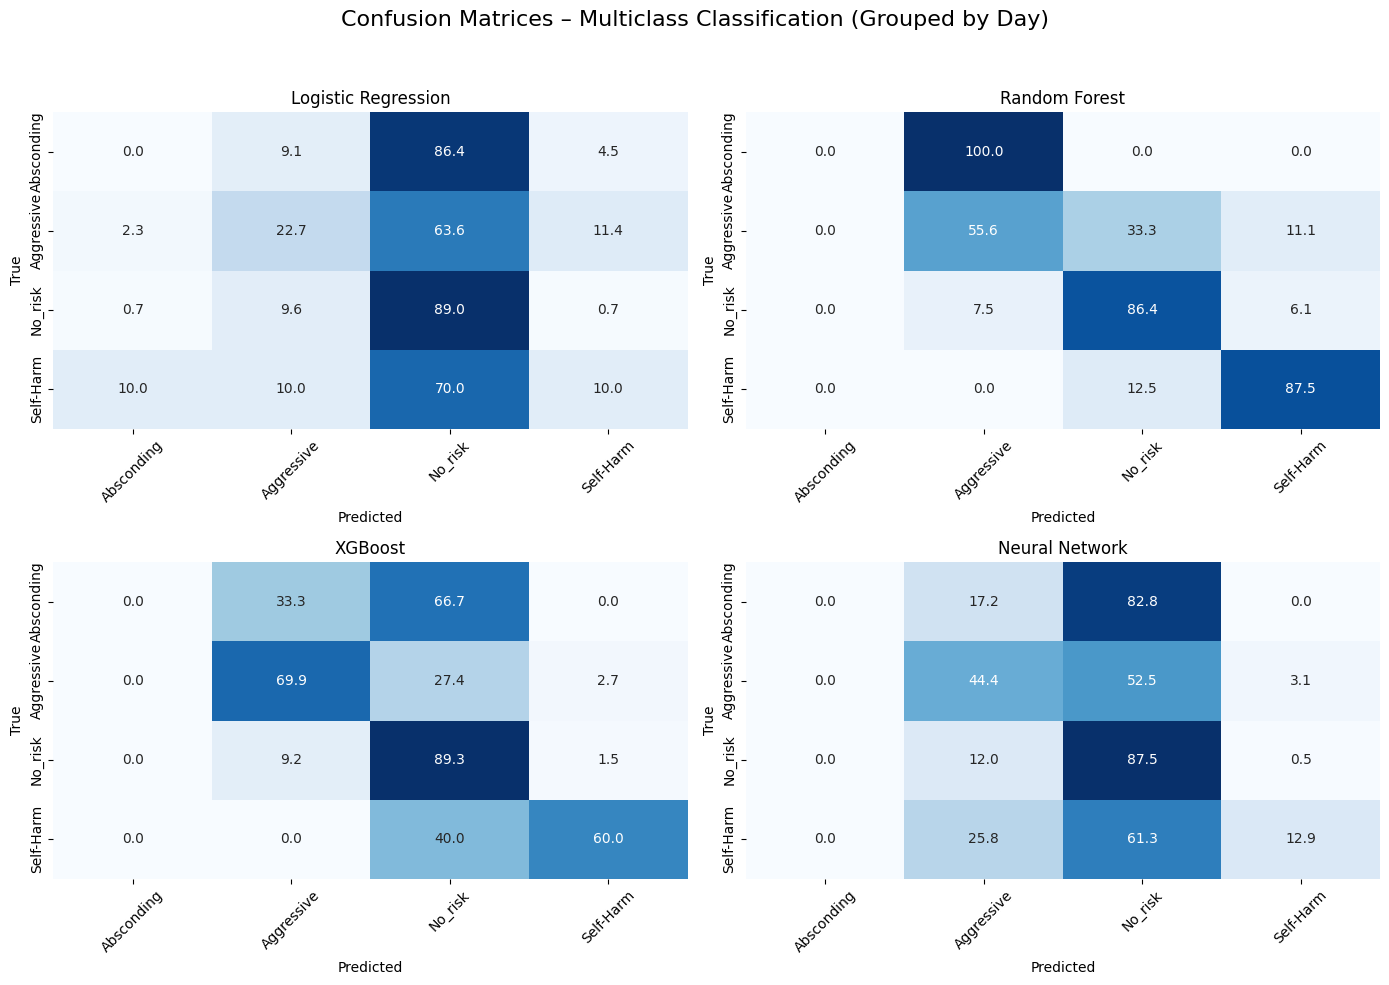

In [85]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def split_predictions(y_true, y_pred, n_models=3):
    total_len = len(y_true)
    block_size = total_len // n_models
    return [(y_true[i*block_size:(i+1)*block_size], y_pred[i*block_size:(i+1)*block_size]) for i in range(n_models)]

multiclass_blocks = split_predictions(y_true_day_mc, y_pred_day_mc, n_models=3)

mapped_blocks = []
for y_t, y_p in multiclass_blocks:
    y_t_named = pd.Series(y_t).map(labels_map)
    y_p_named = pd.Series(y_p).map(labels_map)
    mapped_blocks.append((y_t_named, y_p_named))

mapped_blocks.append((y_true_named_day, y_pred_named_day))

model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']

class_labels = list(labels_map.values())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confusion Matrices – Multiclass Classification (Grouped by Day)', fontsize=16)

for ax, (model_name, (y_true, y_pred)) in zip(axes.flatten(), zip(model_names, mapped_blocks)):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    # Normalize by true labels (rows)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    # Convert NaNs to zero (in case some rows have zero samples)
    cm_normalized = np.nan_to_num(cm_normalized)
    sns.heatmap(cm_normalized * 100, annot=True, fmt='.1f', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

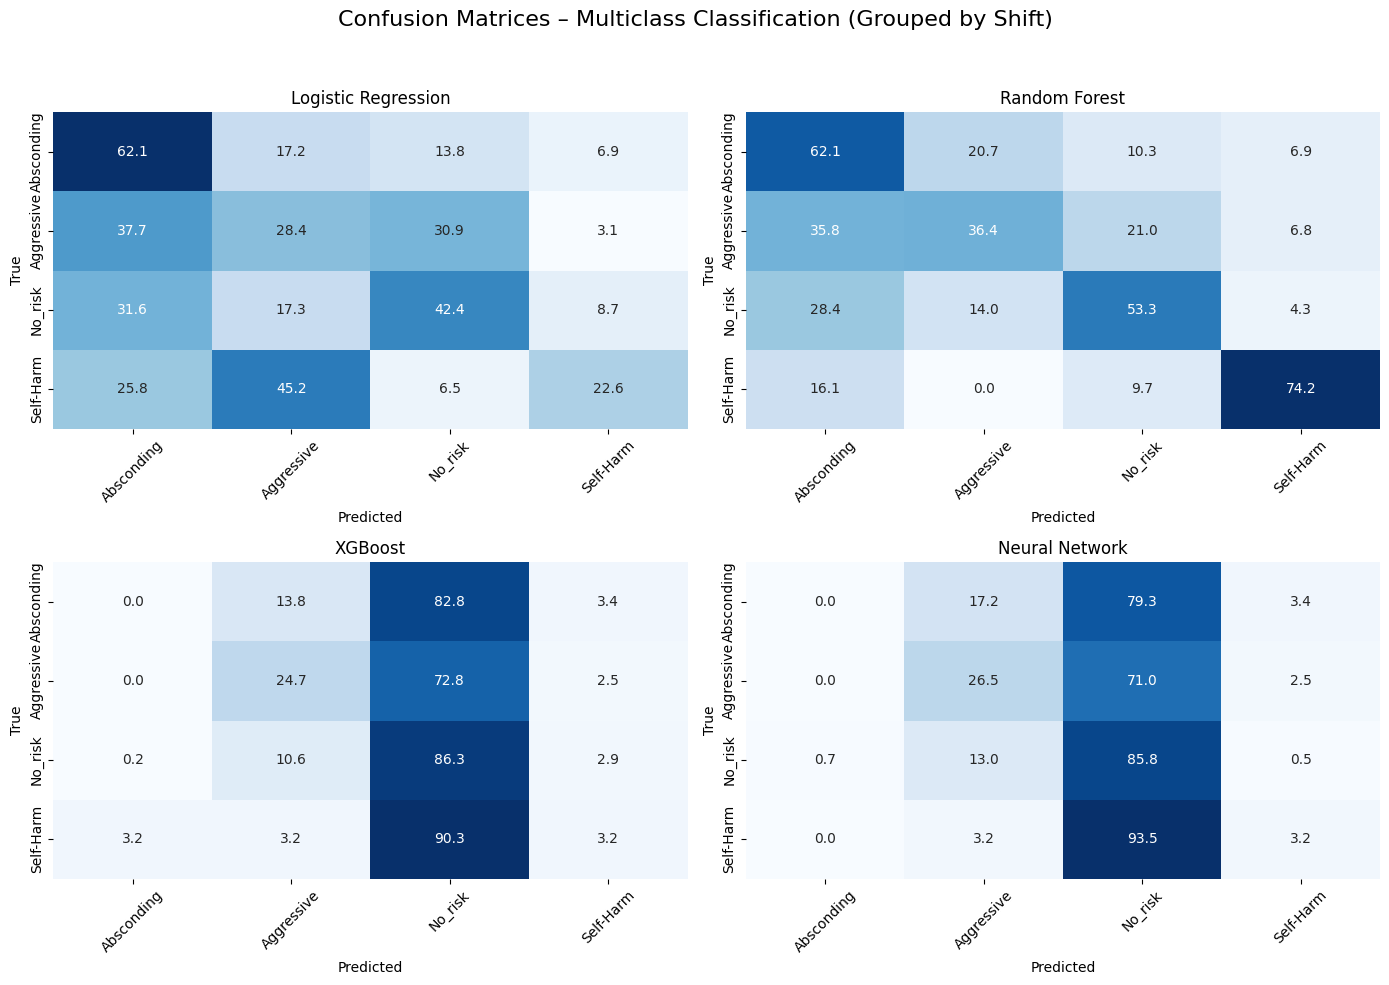

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Labels for multiclass, already in human-readable format
class_labels = list(labels_map.values())

# Prepare true/pred for the first 3 models (need mapping)
models_mc_shift = [
    ('Logistic Regression',
     pd.Series(y_true_mc_log).map(labels_map),
     pd.Series(y_pred_mc_log).map(labels_map)),

    ('Random Forest',
     pd.Series(y_true_mc_rf).map(labels_map),
     pd.Series(y_pred_mc_rf).map(labels_map)),

    ('XGBoost',
     pd.Series(y_true_mc_xgb).map(labels_map),
     pd.Series(y_pred_mc_xgb).map(labels_map)),

    # Neural Net already mapped
    ('Neural Network',
     pd.Series(y_true_named_turno),
     pd.Series(y_pred_named_turno))
]

# Create subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confusion Matrices – Multiclass Classification (Grouped by Shift)', fontsize=16)

# Draw each confusion matrix
for ax, (model_name, y_true, y_pred) in zip(axes.flatten(), models_mc_shift):
    # Ensure only known labels
    mask = y_true.isin(class_labels) & y_pred.isin(class_labels)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Skip if fewer than 2 classes present
    if len(set(y_true)) < 2:
        ax.axis('off')
        ax.set_title(f'{model_name}\n(Only one class present)')
        continue

    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    # Normalización por fila (por etiqueta real)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized = np.nan_to_num(cm_normalized)  # Por si alguna fila suma cero

    sns.heatmap(cm_normalized * 100, annot=True, fmt='.1f', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()